In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder,KBinsDiscretizer
from collections import Counter
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
import time
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from sklearn import metrics

# 1. Exploratory Data Analysis

In [36]:
train = pd.read_csv('../foodpanda/cs-training.csv')
test = pd.read_csv('../foodpanda/cs-test.csv')

## Overview

In [3]:
train.head()
# test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [5]:
train.iloc[:,1:12].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


## Label Distribution 
There are 6.7% of default users and 93.3% of non-default users among the 150000 records in the dataset, which indicates that the dataset is unbalanced.

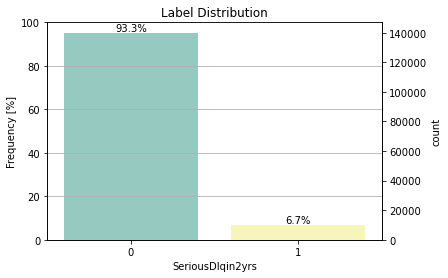

In [6]:
def add_freq():
    ncount=len(train)
    ax2=ax.twinx()
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')
    ax.set_title('Label Distribution')
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount),(x.mean(),y),ha='center',va='bottom')
    ax2.set_ylim(0,100)
    ax2.grid(None)

ax = sns.countplot(x=train['SeriousDlqin2yrs'],palette='Set3')
add_freq()
plt.show()

## Age Distribution
Age Distribution graphs show that people in the age group of 38-48 are more likely to default. And The default population are younger than non-default.

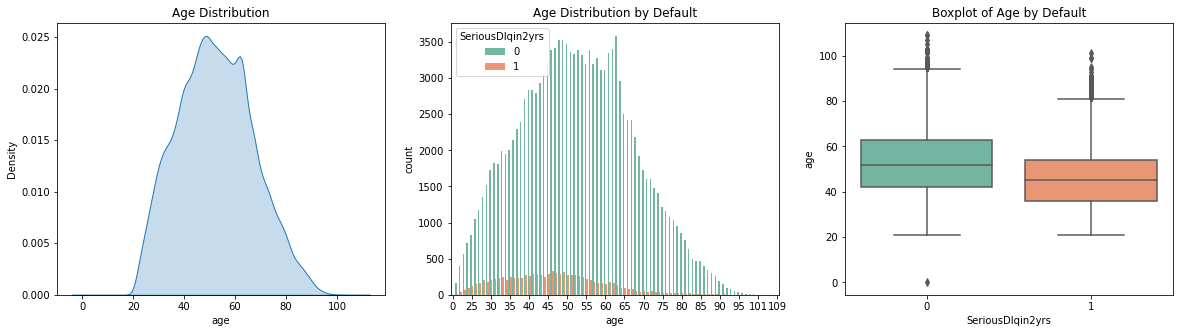

In [7]:
fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

sns.kdeplot(x=train['age'], shade=True,ax=ax1).set_title('Age Distribution')
sns.countplot(x='age', hue='SeriousDlqin2yrs', palette='Set2', data=train, ax=ax2).set_title('Age Distribution by Default')
sns.boxplot(x='SeriousDlqin2yrs', y='age', palette='Set2', data=train, ax=ax3).set_title('Boxplot of Age by Default')

tick_spacing = 5
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.show()

## Family Size Distribution

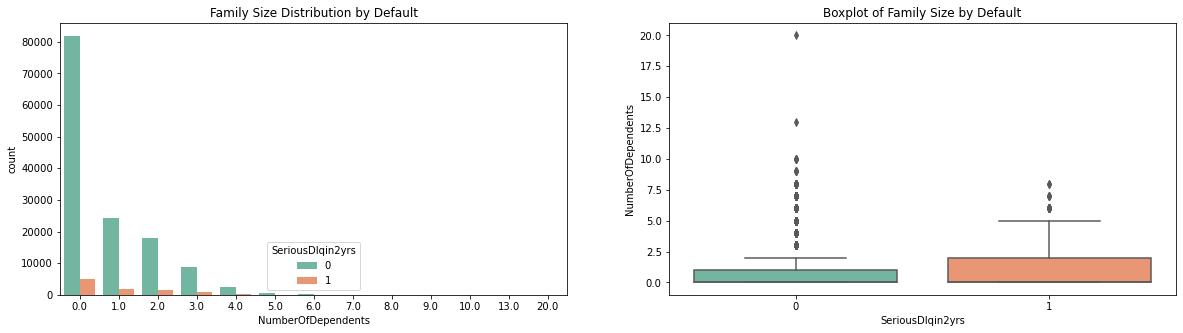

In [8]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(x='NumberOfDependents', hue='SeriousDlqin2yrs', palette='Set2', data=train, ax=ax1).set_title('Family Size Distribution by Default')
sns.boxplot(x='SeriousDlqin2yrs', y='NumberOfDependents', palette='Set2', data=train, ax=ax2).set_title('Boxplot of Family Size by Default')

plt.show()

## Income Distribution
People with monthly income between 2k and 5k are more likely to default.

Monthly income feature is quite skewed and has a long tail, we consider conducting log transformation or binning to get a better distribution.

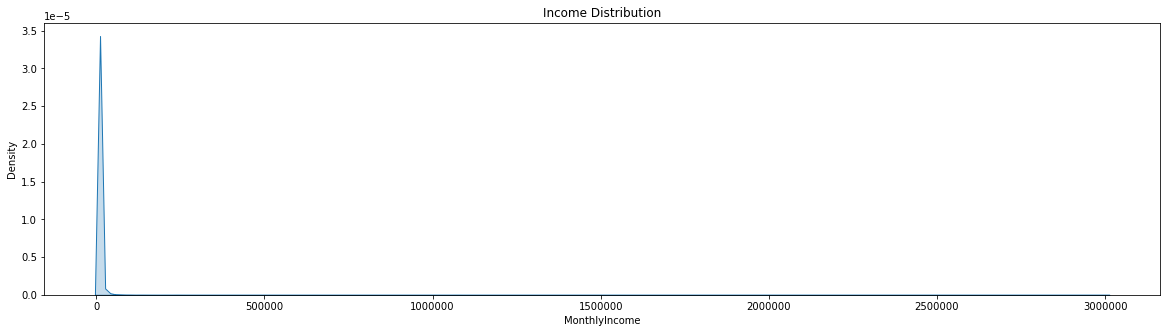

In [9]:
plt.subplots(figsize=(20, 5))
plt.ticklabel_format(style='plain', axis='x')
sns.kdeplot(x=train['MonthlyIncome'], shade=True).set_title('Income Distribution')
plt.show()

In [10]:
# Custom Binning
bins = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,310000]
labels = ['<1k','[1k,2k)','[2k,3k)','[3k,4k)','[4k,5k)','[5k,6k)','[6k,7k)','[7k,8k)','[8k,9k)','[9k,10k)','>10k']
train['MonthlyIncome_bins'] = pd.cut(train['MonthlyIncome'],bins=bins,labels=labels,include_lowest=True)

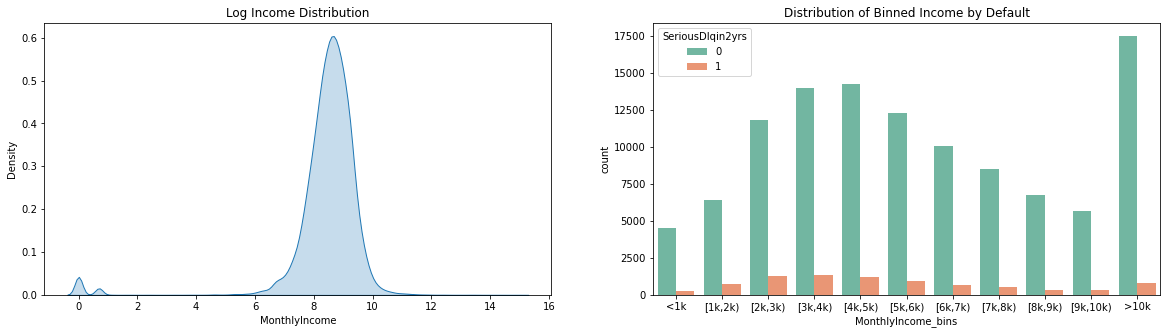

In [11]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.kdeplot(x=np.log(train['MonthlyIncome']+1), shade=True, ax=ax1).set_title('Log Income Distribution')
sns.countplot(x='MonthlyIncome_bins', hue='SeriousDlqin2yrs', palette='Set2', data=train).set_title('Distribution of Binned Income by Default')

plt.show()

## Other financial status distribution
Most of them are extremely skewed and have long tails

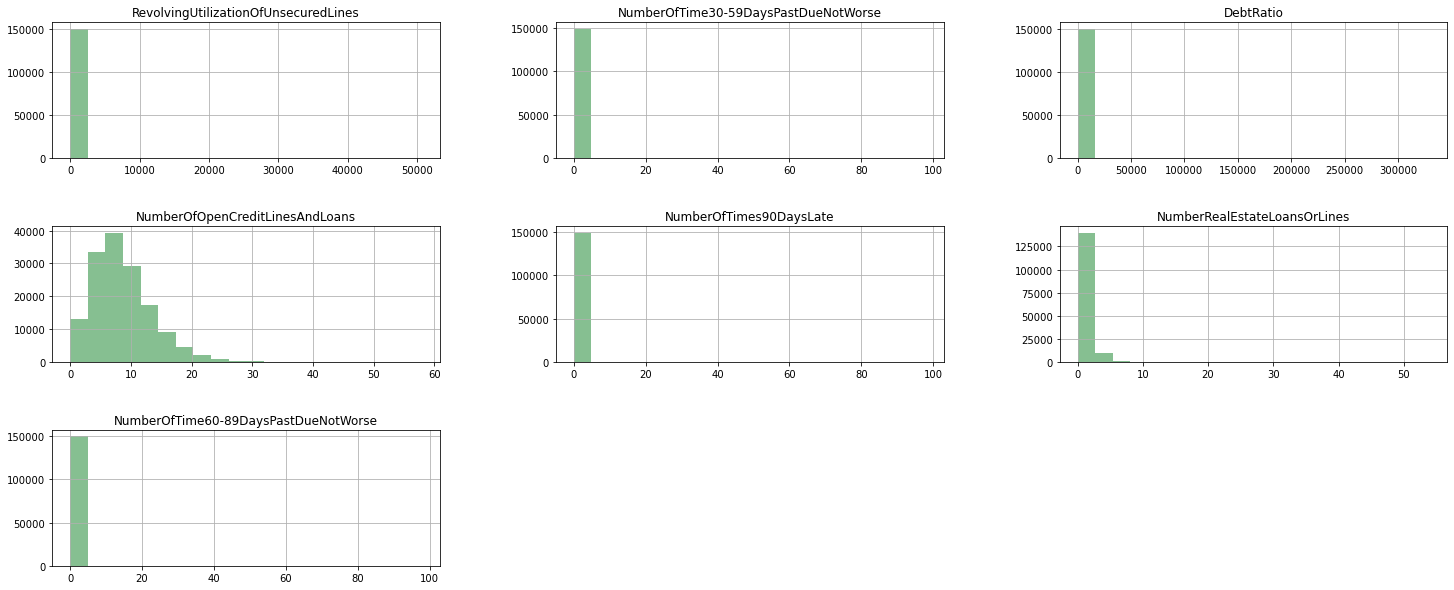

In [12]:
finance_col = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'NumberOfOpenCreditLinesAndLoans', 
               'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse']
train.hist(column = finance_col,figsize=(25,10),color='#86bf91',bins=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

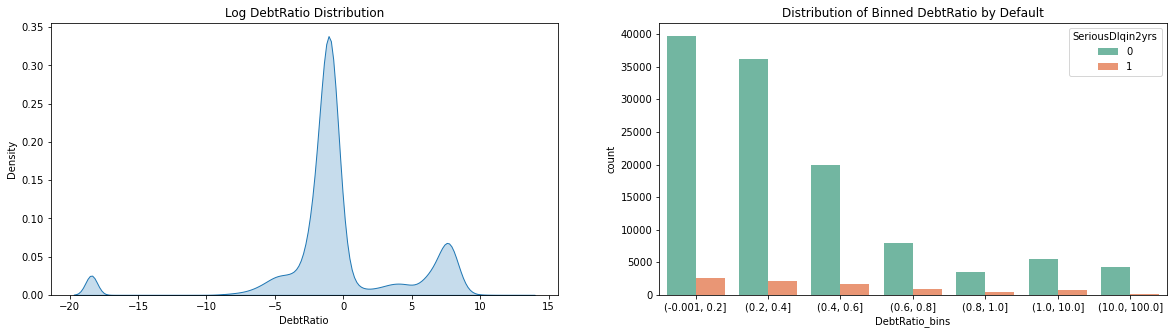

In [61]:
# Custom Binning
bins = [0,0.2,0.4,0.6,0.8,1,10,100]
train['DebtRatio_bins'] = pd.cut(train['DebtRatio'],bins=bins,include_lowest=True)

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sns.kdeplot(x=np.log(train['DebtRatio']+0.00000001), shade=True, ax=ax1).set_title('Log DebtRatio Distribution')
sns.countplot(x='DebtRatio_bins', hue='SeriousDlqin2yrs', palette='Set2', data=train).set_title('Distribution of Binned DebtRatio by Default')

plt.show()

## Correlation and Feature Importance
NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse are highly positively correlated with each other; NumberOfOpenCreditLinesAndLoans and NumberRealEstateLoansOrLines are also positively correlated.

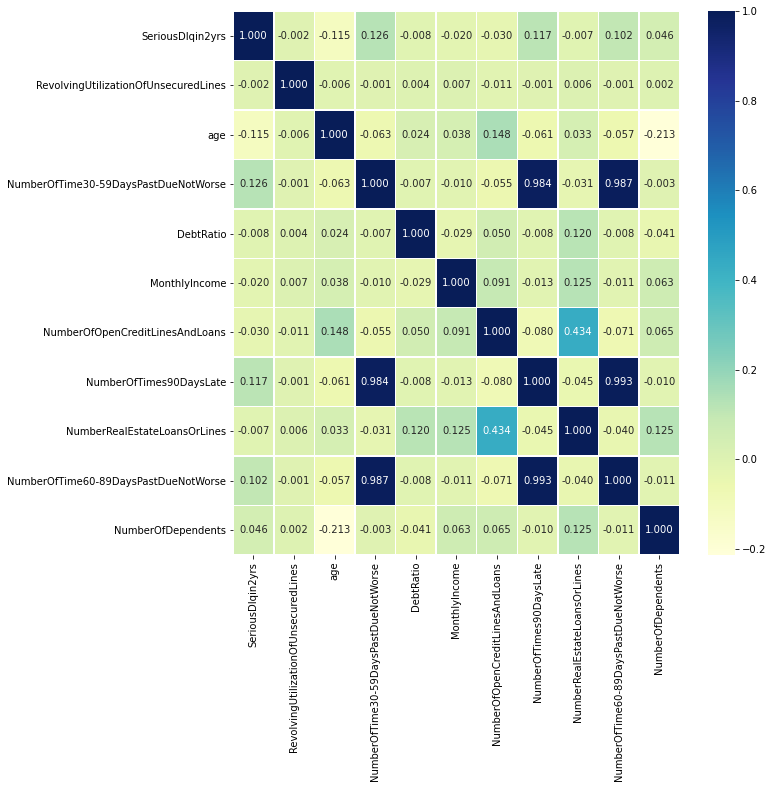

In [13]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.iloc[:,1:12].corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax, cmap="YlGnBu")
plt.show()

# 2. Feature Engineering

## 2.1 Dealing with Missing Value
Only two variables have missing values, they are MonthlyIncome and NumberofDependents. Here use Mode to fill in MonthlyIncome's missing values because MonthlyIncome contains some extreme values which may have influence on mean. As for NumberofDependents, because it only has 2626 missing values, so here directly drop those rows.

In [37]:
train.isnull().sum()
# test.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [38]:
train['MonthlyIncome'].fillna(train['MonthlyIncome'].mode()[0],inplace=True)
test['MonthlyIncome'].fillna(train['MonthlyIncome'].mode()[0],inplace=True)
train['NumberOfDependents'].fillna(train['NumberOfDependents'].mode()[0],inplace=True)
test['NumberOfDependents'].fillna(train['NumberOfDependents'].mode()[0],inplace=True)

## 2.2 Dealing with skewed variables

In [39]:
# get X and y
X = train.drop(['SeriousDlqin2yrs','Unnamed: 0'],axis=1)
y = train['SeriousDlqin2yrs']
X_test = test.drop(['SeriousDlqin2yrs','Unnamed: 0'],axis=1)

In [ ]:
# bin_col = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 
#            'DebtRatio', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse','NumberOfOpenCreditLinesAndLoans', 
#            'NumberRealEstateLoansOrLines']

# # Bin encoding
# est = KBinsDiscretizer(n_bins=6,encode='ordinal',strategy='Kmeans')
# X[bin_col] = est.fit_transform(X[bin_col])
# X_test[bin_col] = est.fit_transform(X_test[bin_col])

# #Log transform
# X['MonthlyIncome'] = np.log(X['MonthlyIncome']+1)
# X_test['MonthlyIncome'] = np.log(X_test['MonthlyIncome']+1)

## 2.3 Resampling for imbalanced dataset

Because the two classes of the dataset is of very different size, so we need to use resampling method to handle the imbalance. There are three types of methods - oversampling, undersampling and combined both. We will use them on our training set (in 5 fold cross validation) and train the model to see which one is better.

In [22]:
methods = ['SMOTE', 'SMOTEENN', 'EditedNearestNeighbours']
def sampling(method,ratio=1,random_state=1):
    sp =None
    method=int(method)
    method =methods[method]
    if method=='SMOTE':
        sp = SMOTE(random_state=random_state,sampling_strategy=ratio)
    if method=='SMOTEENN':
        sp = SMOTEENN(random_state=random_state,sampling_strategy=ratio)
    if method=='EditedNearestNeighbours':
        sp = EditedNearestNeighbours()
    return sp

# 3. Model Training

## 3.1 evaluation metrics
MCC is useful when the two classes are of very different sizes, and that’s why we choose it. Then we use 5-fold cross validation and mean MCC of 5 experiments to evaluate model performance. Feature selection and resampling methods are performed on the training set after we split the 5-fold datasets.

In [51]:
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

def eval_mcc_best(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        #print(best_proba, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        y_pred = (y_prob >= best_proba).astype(int)
        return best_proba,best_mcc,y_pred

In [29]:
kf = KFold(n_splits=5,shuffle=True,random_state=1)

In [28]:
class Color:
    Black = 0
    Red = 1
    Green = 2
    Yellow = 3
    Blue = 4
    Magenta = 5
    Cyan = 6
    White = 7

class Mode:
    Foreground = 30
    Background = 40
    ForegroundBright = 90
    BackgroundBright = 100

def tcolor(c, m=Mode.Foreground):
    return '\033[{}m'.format(m + c)

def treset():
    return '\033[0m'

In [49]:
def tuning_objective(space):
    time1 = time.time()
    print('--------------------------')
    print(tcolor(Color.Green,Mode.Foreground)+'New Iteration Started'+ treset())
    
    
    MCCs =[]
    ACCs = []
    i = 1
    
    '''
    param用于模型参数
    '''
    param = {
        'n_estimators': int(space['n_estimators']),
        'max_depth': int(space['max_depth']),
        'subsample': "{:.2f}".format(space['subsample']),
        'reg_alpha': "{:.3f}".format(space['reg_alpha']),
        'reg_lambda': "{:.3f}".format(space['reg_lambda']),
        'learning_rate': "{:.3f}".format(space['learning_rate']),
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'min_child_weight': '{:.3f}'.format(space['min_child_weight']),
    }
    print(param)
    
    for train_ind, val_ind in kf.split(X):
        print('----------------Fold {} -----------------'.format(i))
        i+=1
        X_train,y_train = X.iloc[train_ind,:],y[train_ind]
        X_train.index,y_train.index=list(range(0,len(y_train))),list(range(0,len(y_train)))
        X_val, y_val = X.iloc[val_ind,:],y[val_ind]
        X_val.index,y_val.index=list(range(0,len(y_val))),list(range(0,len(y_val)))
        
        
        '''
        Oversampling
        '''
        print('Original dataset shape %s' % Counter(y_train))
        sp = sampling(method=space['sample_method'])
        X_res, y_res = sp.fit_resample(X_train, y_train)
        print('Resampled dataset shape %s' % Counter(y_res))
        

        '''
        Model Part
        '''

        lightGBM=lgb.LGBMClassifier(
              random_state=1,**param
        )
        lightGBM.fit(
        X_res,y_res,eval_set=[(X_res, y_res), (X_val, y_val)],
            verbose=False,early_stopping_rounds=10
        )

        y_train_pro = lightGBM.predict_proba(X_res)[:,1]
        y_val_pro = lightGBM.predict_proba(X_val)[:,1]
        
    
        best_train_pro,train_mcc,y_train_pre = eval_mcc_best(y_true=y_res,y_prob=y_train_pro)
        Best_th_val,Best_mcc_val,_ = eval_mcc_best(y_true=y_val,y_prob=y_val_pro)

        y_val_pre = [1*(i>=0.5) for i in y_val_pro]

        val_mcc = matthews_corrcoef(y_val_pre,y_val)
        val_acc = accuracy_score(y_val_pre,y_val)

        each_result ={
            'TrainACC':accuracy_score(y_train_pre,y_res),
            'TrainMCC':train_mcc,
            'Threshold':best_train_pro,
            'ValACC':val_acc,
            'Best_th_val':Best_th_val,
            'Best_mcc_val':Best_mcc_val,

        }
        print(each_result)
        #confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_val_pre,y_val).ravel()
        print('Val Data Confusion Matrix')
        print('{}  {}'.format(tp,fn))
        print('{}  {}'.format(fp,tn))
        #
        MCCs.append(val_mcc)
        ACCs.append(val_acc)
    #record parameters result for this round
    Para_list.append(space)
    MCCs_list.append(np.mean(MCCs))
    ACCs_list.append(np.mean(ACCs))
    #print mean mcc,acc    
    print(tcolor(Color.Green,Mode.Foreground)+ '[Iteration: Mean_MCC:{}  Mean_ACCURACY:{}]'.format(np.mean(MCCs),np.mean(ACCs)) + treset())

    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    
    return -(np.mean(MCCs))

In [48]:
space = {

    ##############################
    #model parameters
        'n_estimators': hp.quniform('n_estimators', 400, 1200, 100),
        'max_depth': hp.quniform('max_depth',6, 10, 1),
        'reg_alpha': hp.uniform('reg_alpha', 0.05, 0.3),
        'reg_lambda': hp.quniform('reg_lambda', 0.0, 1.8,0.1),
        'subsample': hp.uniform('subsample', 0.6, 1),
        'learning_rate': hp.quniform('learning_rate', 0.001, 0.4,0.05),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': hp.choice('min_child_weight',list(range(1,3))),
    ##############################
    #resampling methods
        'sample_method':hp.choice('sample_method',[0,1,2])
    
    }

MCCs_list =[]
ACCs_list = []
Para_list = []

In [50]:
trials= Trials()
best = fmin(
    fn=tuning_objective,
    space=space,
    algo=tpe.suggest,trials=trials,
    max_evals=1
)

--------------------------                                                                                             
New Iteration Started                                                                                         
{'n_estimators': 500, 'max_depth': 7, 'subsample': '0.74', 'reg_alpha': '0.160', 'reg_lambda': '1.000', 'learning_rate': '0.250', 'colsample_bytree': '0.668', 'min_child_weight': '2.000'}
----------------Fold 1 -----------------                                                                               
Original dataset shape Counter({0: 111987, 1: 8013})                                                                   
Resampled dataset shape Counter({0: 97576, 1: 8013})                                                                   
{'TrainACC': 0.9258824309350406, 'TrainMCC': 1.0, 'Threshold': 0.2585919981714912, 'ValACC': 0.9344333333333333, 'Best_th_val': 0.9257057565491759, 'Best_mcc_val': 0.01699818098630532}
Val Data Confusion Matrix           

In [51]:
print(best)

{'colsample_bytree': 0.668397048202969, 'learning_rate': 0.25, 'max_depth': 7.0, 'min_child_weight': 1, 'n_estimators': 500.0, 'reg_alpha': 0.1602764201831674, 'reg_lambda': 1.0, 'sample_method': 2, 'subsample': 0.7396156494760213}


# Model prediction

In [52]:
# use combined resampling method on training set
enn = EditedNearestNeighbours()
X_under, y_under = enn.fit_resample(X, y)

In [53]:
clf = lgb.LGBMClassifier(
    random_state = 1,
    colsample_bytree = 0.668397048202969, 
    learning_rate = 0.25, 
    max_depth = 7, 
    min_child_weight = 1, 
    n_estimators = 500, 
    reg_alpha = 0.1602764201831674,
    reg_lambda = 1, 
    subsample = 0.7396156494760213
)
clf.fit(X_under, y_under)
y_pred_pro = clf.predict_proba(X_test)[:,1]

In [56]:
sub = pd.read_csv('../foodpanda/sampleEntry.csv')
sub['Probability'] = y_pred_pro
sub.to_csv('sub.csv',index=False)

In [55]:
sub.head()

,Id,Probability
0,1,0.042209
1,2,0.041311
2,3,0.015364
3,4,0.052446
4,5,0.196845


## Business Insight
DebtRatio, Income, Utilization of credit limits, Age play an important role when we predict whether a person will defualt or not. People at middle age and with stable monthly income are less likely to default. And those have lower DebtRatio also has less probability to default.

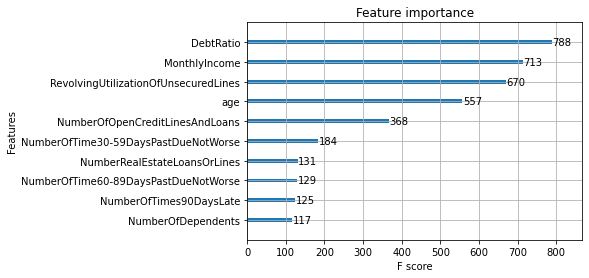

In [59]:
# fit model no training data
model = XGBClassifier(objective = "binary:logistic", eval_metric = "logloss", use_label_encoder=False)
model.fit(X_under, y_under)
# plot feature importance
plot_importance(model)
plt.show()